# Цель лабораторной работы
Изучить ансамбли моделей машинного обучения<cite data-cite="ue:lab6"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab6"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество модели с&nbsp;помощью одной из&nbsp;подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра. В&nbsp;зависимости от&nbsp;используемой библиотеки можно применять функцию `GridSearchCV`, использовать перебор параметров в&nbsp;цикле, или использовать другие методы.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются метрологические данные с&nbsp;метеостанции HI-SEAS (Hawaii Space Exploration Analog and Simulation) за&nbsp;четыре месяца (с&nbsp;сентября по&nbsp;декабрь 2016&nbsp;года)<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("./SolarPrediction.csv")

Преобразуем временные колонки в соответствующий временной формат:

In [4]:
data["Time"] = (pd
                    .to_datetime(data["UNIXTime"], unit="s", utc=True)
                    .dt.tz_convert("Pacific/Honolulu")).dt.time

data["TimeSunRise"] = (pd
                       .to_datetime(data["TimeSunRise"],
                                    infer_datetime_format=True)
                       .dt.time)

data["TimeSunSet"] = (pd
                      .to_datetime(data["TimeSunSet"],
                                   infer_datetime_format=True)
                      .dt.time)

data = data.rename({"WindDirection(Degrees)": "WindDirection"},
                   axis=1)

Проверим полученные типы:

In [5]:
data.dtypes

UNIXTime           int64
Data              object
Time              object
Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
TimeSunRise       object
TimeSunSet        object
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [6]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Очевидно, что все эти временные характеристики в&nbsp;таком виде нам не&nbsp;особо интересны. Преобразуем все нечисловые столбцы в&nbsp;числовые. В&nbsp;целом колонка `UNIXTime` нам не&nbsp;интересна, дата скорее интереснее в&nbsp;виде дня в&nbsp;году. Время измерения может быть интересно в&nbsp;двух видах: просто секунды с&nbsp;полуночи, и время, нормализованное относительно рассвета и заката. Для&nbsp;преобразования времени в&nbsp;секунды используем следующий метод<cite data-cite="so:dttseconds"></cite>:

In [7]:
def time_to_second(t):
    return ((datetime.combine(datetime.min, t) - datetime.min)
            .total_seconds())

In [8]:
df = data.copy()

timeInSeconds = df["Time"].map(time_to_second)

sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)

df = df.drop(["UNIXTime", "Data", "Time",
              "TimeSunRise", "TimeSunSet"], axis=1)

df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [9]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

С&nbsp;такими данными уже можно работать. Проверим размер набора данных:

In [10]:
df.shape

(32686, 7)

Проверим основные статистические характеристики набора данных:

In [11]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0.482959
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.602432
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,-0.634602
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,-0.040139
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0.484332
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.006038
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.566061


Проверим наличие пропусков в&nbsp;данных:

In [12]:
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [13]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]

In [14]:
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [15]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


Предобработаем данные, чтобы методы работали лучше:

In [16]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04
mean,5.565041e-16,2.904952e-14,1.391260e-17,6.956302e-17,-9.738822e-17,5.217226e-18
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.758117e+00,-4.259540e+00,-2.578560e+00,-1.724255e+00,-1.788859e+00,-1.855112e+00
25%,-8.229646e-01,-4.184734e-01,-7.316829e-01,-7.366250e-01,-8.233591e-01,-8.683240e-01
50%,-1.779139e-01,1.302504e-01,3.841386e-01,5.062367e-02,-1.787376e-01,2.279483e-03
75%,6.283995e-01,6.789742e-01,8.458578e-01,4.307058e-01,4.658840e-01,8.682924e-01
max,3.208603e+00,2.508053e+00,1.076717e+00,2.602741e+00,9.814329e+00,1.797910e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [19]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Случайный лес

Попробуем случайный лес с&nbsp;гиперпараметром $n=100$:

In [20]:
ran_100 = RandomForestRegressor(n_estimators=100)
ran_100.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [21]:
test_model(ran_100)

mean_absolute_error: 37.95207219774841
median_absolute_error: 0.6220499999999998
r2_score: 0.9159020321173837


Видно, что данный метод даже без&nbsp;настройки гиперпараметров уже показывает очень неплохой результат.

### Градиентный бустинг

Попробуем градиентный бустинг с&nbsp;гиперпараметром $n=100$:

In [22]:
gr_100 = GradientBoostingRegressor(n_estimators=100)
gr_100.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [23]:
test_model(gr_100)

mean_absolute_error: 58.07682041283237
median_absolute_error: 14.741421993961083
r2_score: 0.8729966247836403


Внезапно градиентный бустинг оказался несколько хуже по&nbsp;сравнению со&nbsp;случайным лесом.

## Подбор гиперпараметра $n$

### Случайный лес

Введем список настраиваемых параметров:

In [24]:
param_range = np.arange(10, 201, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [25]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=140,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

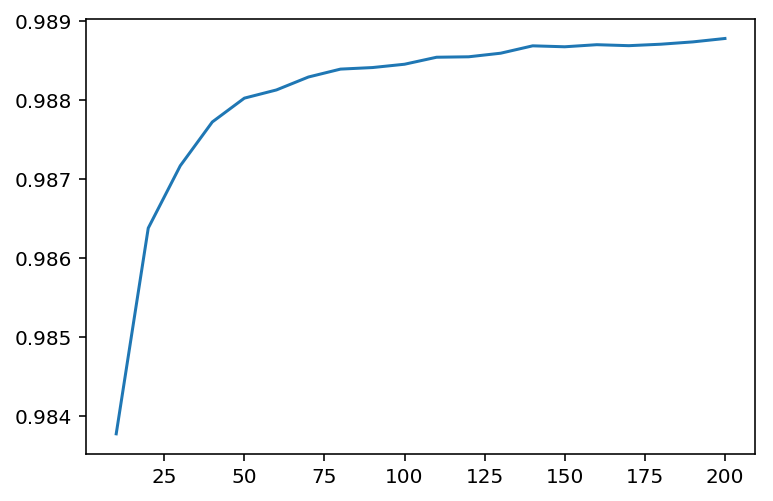

In [26]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В&nbsp;целом результат ожидаемый&nbsp;— чем больше обученных моделей, тем лучше.

На&nbsp;тестовом наборе данных картина похожа:

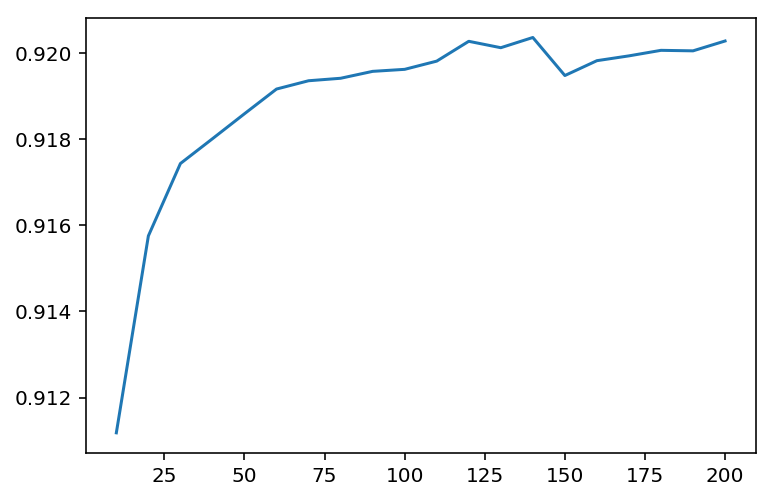

In [27]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Из-за случайнойсти график немного плавает, но конкретно в&nbsp;данном случае получился чётко выраженный пик с&nbsp;наилучшим результатом.

In [28]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 38.05719305468149
median_absolute_error: 0.5875714285714564
r2_score: 0.9153161369077153


Конкретно данная модель оказалась заметно лучше, чем исходная.

### Градиентный бустинг

Список настраиваемых параметров оставим тем же.

In [29]:
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [30]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

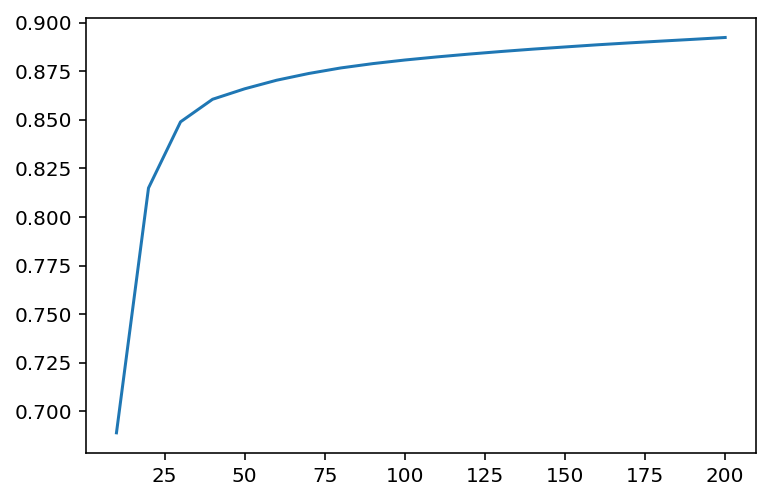

In [31]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Картина та же: чем больше подмоделей, тем лучше.

На&nbsp;тестовом наборе данных картина ровно та же:

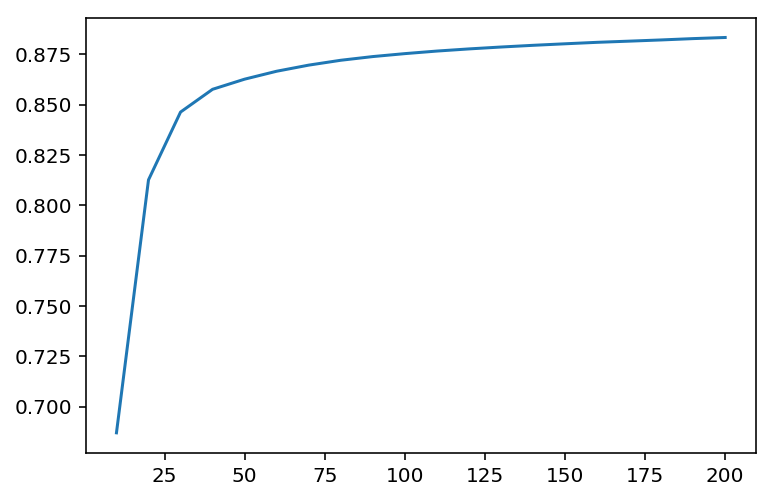

In [32]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Выходит, что чем больше подмоделей, тем лучше. Возможно, что можно использовать ещё больше моделей, но будем считать, что это выходит за&nbsp;рамки лабораторной работы.

In [33]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 55.85158117939845
median_absolute_error: 14.572172035170738
r2_score: 0.8810188676083276
